In [16]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [18]:
# 1. Generate nonlinear synthetic data
torch.manual_seed(0)
N = 100
X = torch.linspace(-2, 2, N).unsqueeze(1)
y = torch.sin(3 * X) + 0.3 * torch.randn_like(X)

# 2. Simple MLP model
class BayesianMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 32),
            nn.Tanh(),
            nn.Linear(32, 32),
            nn.Tanh(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x)

In [24]:
# 3. SGLD training function
def sgld_train(model, X, y, lr=1e-2, noise_std=1e-2, n_steps=3000, burn_in=1000):
    samples = []
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    for step in range(n_steps):
        model.train()
        optimizer.zero_grad()
        preds = model(X)
        loss = ((preds - y)**2).mean()
        loss.backward()

        with torch.no_grad():
            for p in model.parameters():
                if p.grad is not None:
                    noise = torch.randn_like(p) * (2 * lr * noise_std)**0.5
                    p.add_(-lr * p.grad + noise)

        if step >= burn_in and step % 10 == 0:
            samples.append({k: v.detach().clone() for k, v in model.state_dict().items()})

    return samples


In [27]:

# 4. Train with SGLD
model = BayesianMLP()
samples = sgld_train(model, X, y)

# 5. Predictive posterior
X_test = torch.linspace(-4, 4, 200).unsqueeze(1)
predictions = []

for s in samples[::20]:  # Thin samples for plotting
    model.load_state_dict(s)
    with torch.no_grad():
        y_pred = model(X_test).squeeze()
        predictions.append(y_pred)

predictions = torch.stack(predictions)

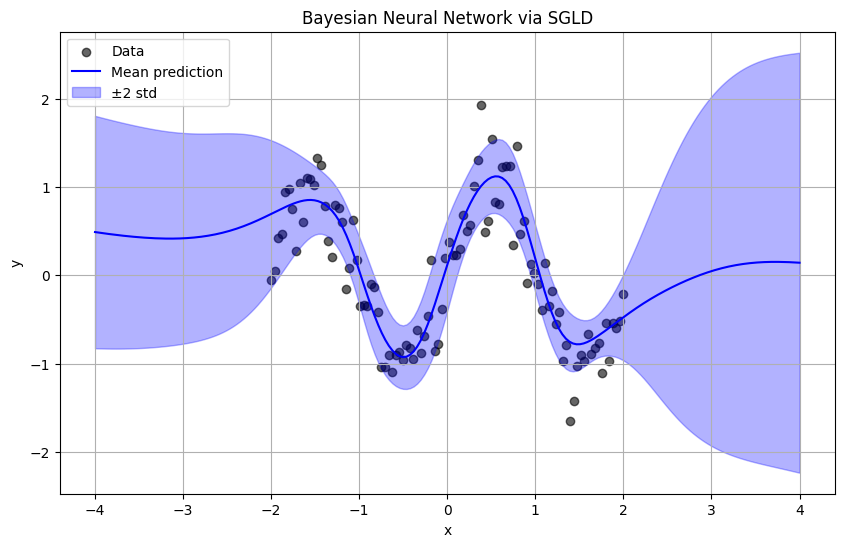

In [28]:
# 6. Plot
mean_pred = predictions.mean(0)
std_pred = predictions.std(0)

plt.figure(figsize=(10, 6))
plt.scatter(X.numpy(), y.numpy(), color='black', label="Data", alpha=0.6)
plt.plot(X_test.numpy(), mean_pred.numpy(), label="Mean prediction", color="blue")
plt.fill_between(
    X_test.squeeze().numpy(),
    (mean_pred - 2 * std_pred).numpy(),
    (mean_pred + 2 * std_pred).numpy(),
    alpha=0.3, color="blue", label="±2 std"
)
plt.title("Bayesian Neural Network via SGLD")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.show()